In [14]:
# !conda install matplotlib -y

In [29]:
from PIL import Image
import cv2
import pytesseract
import numpy as np
from rembg import remove
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

Step 1: Remove the background

(-0.5, 999.5, 657.5, -0.5)

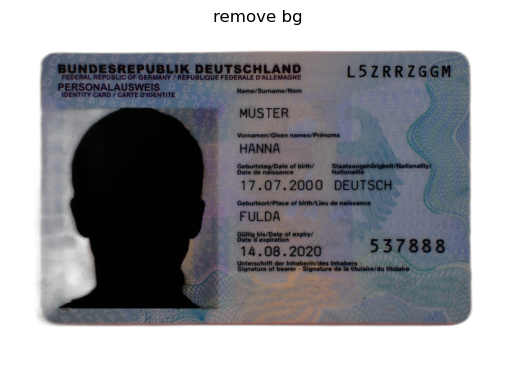

In [32]:
image = cv2.imread('../data/raw/ausweis_deutsch2.jpg') 

input_array = np.array(image)
output_array = remove(input_array)

# Create a PIL Image from the output array
output_image = Image.fromarray(output_array)
plt.imshow(output_image) 
plt.title('remove bg')  
plt.axis('off')


Step 2: Convert the image to gray

(-0.5, 999.5, 657.5, -0.5)

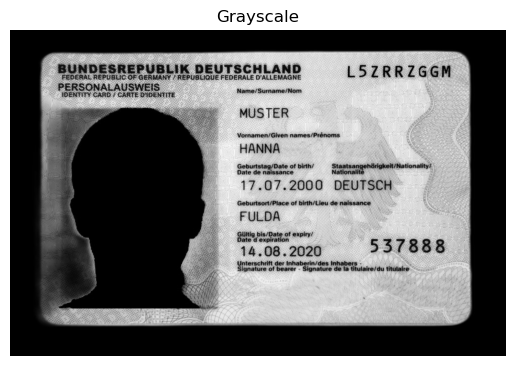

In [37]:
# Use the cvtColor() function to grayscale the image 
gray_image = cv2.cvtColor(output_array, cv2.COLOR_BGR2GRAY) 
  
plt.imshow(gray_image, cmap='gray') 
plt.title('Grayscale')  
plt.axis('off')

Try remove noise with median filter using different kernels.

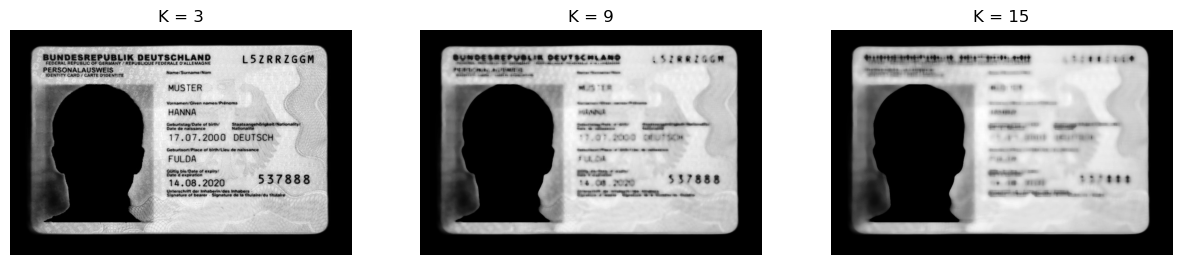

In [38]:
figure, axes = plt.subplots(1, 3, figsize = (15, 10))
k_values = [3, 9, 15]
# Apply median blur and display
for i, k in enumerate(k_values):
    # Apply a "median" blur to the image
    blurred = cv2.medianBlur(gray_image, k)
    
    # Display the blurred image in the subplot
    axes[i].imshow(blurred, cmap='gray')
    axes[i].set_title(f"K = {k}")
    axes[i].axis('off')  # Hide axis

plt.show()


Try bilateral filter to remove the noise. Use different params to get the best result.

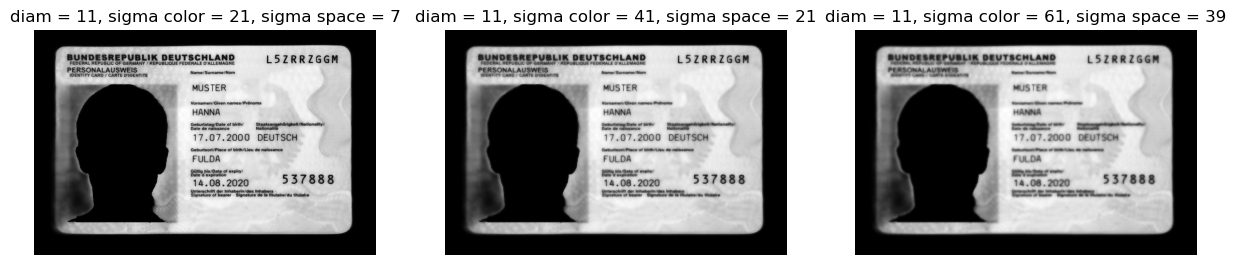

In [39]:
figure, axes = plt.subplots(1, 3, figsize = (15, 10))

params = [(11, 21, 7), (11, 41, 21), (11, 61, 39)]


# loop over the diameter, sigma color, and sigma space
for i, (diameter, sigmaColor, sigmaSpace) in enumerate(params):
    # apply bilateral filtering to the image using the current set of
    # parameters
    blurred = cv2.bilateralFilter(gray_image, diameter, sigmaColor, sigmaSpace)
    # show the output image and associated parameters
    title = "Blurred d={}, sc={}, ss={}".format(diameter, sigmaColor, sigmaSpace)
    axes[i].imshow(blurred, cmap='gray')
    axes[i].set_title(f"diam = {diameter}, sigma color = {sigmaColor}, sigma space = {sigmaSpace}")
    axes[i].axis('off')  # Hide axis

plt.show()


Step 3: Apply Bilateral Filter

In [40]:
diameter, sigmaColor, sigmaSpace = 11, 21, 7
blurred = cv2.bilateralFilter(gray_image, diameter, sigmaColor, sigmaSpace)

Step 4: Stretch Image

(-0.5, 779.5, 379.5, -0.5)

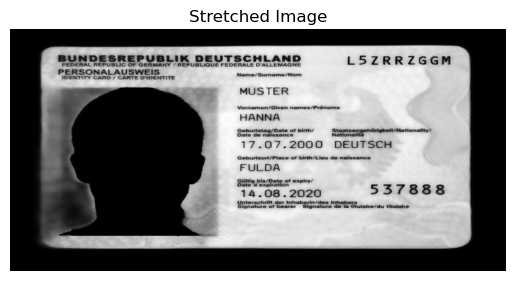

In [41]:
stretch_near = cv2.resize(blurred, (780, 380), 
               interpolation = cv2.INTER_LINEAR)
plt.imshow(stretch_near, cmap='gray') 
plt.title('Stretched Image')  
plt.axis('off')

Try to enhance text quality by opening image: 

(-0.5, 779.5, 379.5, -0.5)

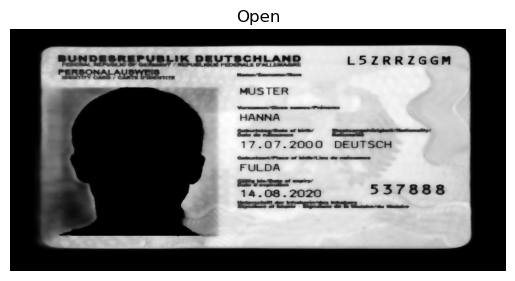

In [42]:
kernel = np.ones((3, 3), np.uint8)
open = cv2.morphologyEx(stretch_near, cv2.MORPH_OPEN, kernel)
plt.imshow(open, cmap='gray') 
plt.title('Open')
plt.axis('off')

Try to enhance text quality by dilating image: 

(-0.5, 779.5, 379.5, -0.5)

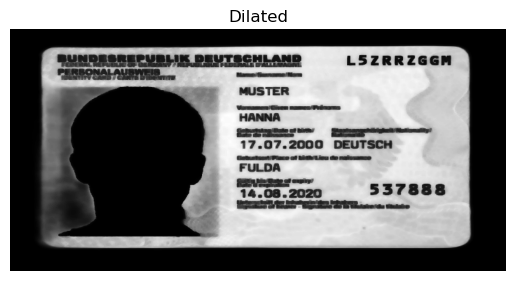

In [43]:
kernel = np.ones((3, 3), np.uint8)
img_dilation = cv2.erode(stretch_near, kernel, iterations=1)
plt.imshow(img_dilation, cmap='gray') 
plt.title('Dilated')
plt.axis('off')

Step 5: Apply Canny for edge detection:

(-0.5, 779.5, 379.5, -0.5)

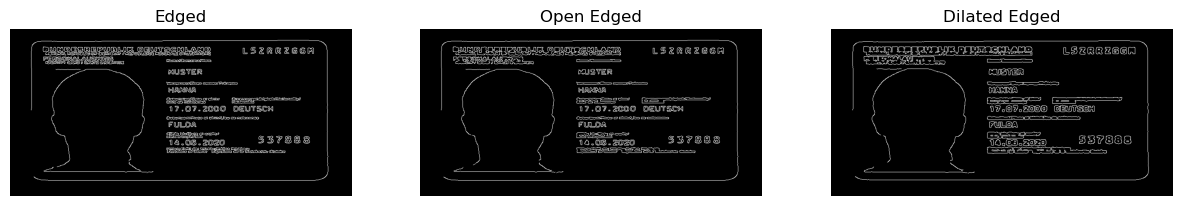

In [44]:
t_lower = 100
t_upper = 150
edged = cv2.Canny(stretch_near, t_lower, t_upper)
edged_open = cv2.Canny(open, t_lower, t_upper)
edged_dil = cv2.Canny(img_dilation, t_lower, t_upper)
edged_dil = cv2.Canny(close, t_lower, t_upper)

fig, axes = plt.subplots(1, 3, figsize=(15, 7))
axes[0].imshow(edged, cmap='gray')
axes[0].set_title(f"Edged")
axes[0].axis('off')  # Hide axis

axes[1].imshow(edged_open, cmap='gray')
axes[1].set_title(f"Open Edged")
axes[1].axis('off')

axes[2].imshow(edged_dil, cmap='gray')
axes[2].set_title(f"Dilated Edged")
axes[2].axis('off')

axes[3].imshow(edged_dil, cmap='gray')
axes[3].set_title(f"Dilated Edged")
axes[3].axis('off')



Try to enhance text quality by closing edged image: 

(-0.5, 779.5, 379.5, -0.5)

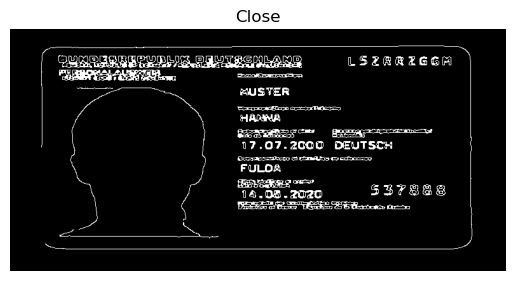

In [179]:
kernel = np.ones((2, 2), np.uint8)
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel, iterations=1) 
plt.imshow(closed, cmap='gray') 
plt.title('Close')
plt.axis('off')

Step 6: find contours in edged image, then extract the contour of the max size:

In [45]:
refCnts, hierarchy = cv2.findContours(stretch_near, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [46]:
def get_max_size_cnt(cnts):
    max_size_index = 0
    max_size = 0
    for i, cnt in enumerate(cnts):
        if cnt.size > max_size:
            max_size = cnt.size
            max_size_index = i
    return max_size, max_size_index

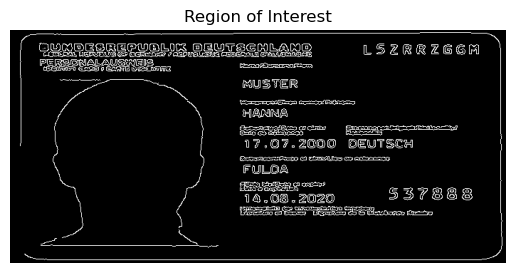

In [76]:
max_cnt_size, max_cnt_size_index = get_max_size_cnt(refCnts)
x, y, w, h = cv2.boundingRect(refCnts[max_cnt_size_index])
roi = edged[y:y + h, x:x + w]
# Display the region of interest (ROI) using matplotlib
plt.imshow(roi, cmap='gray')
plt.title('Region of Interest')
plt.axis('off')
plt.show()

Step 7: extract RoIs in the image:

In [218]:
def extract_firstname_roi(img, axes):    
    roi_nrows = img.shape[0]
    roi_ncols = img.shape[1]
    firstname_roi = img[33*roi_nrows//100: 2*roi_nrows//5, 2*roi_ncols//5: 95*roi_ncols//100]
    axes.imshow(firstname_roi, cmap='gray')
    axes.set_title('first name roi')
    axes.axis('off')
    return firstname_roi

def extract_lastname_roi(img, axes):
    roi_nrows = img.shape[0]
    roi_ncols = img.shape[1]
    lastname_roi = img[roi_nrows//6: 3*roi_nrows//10, 2*roi_ncols//5: 95*roi_ncols//100]
    axes.imshow(lastname_roi, cmap='gray')
    axes.set_title('last name roi')
    axes.axis('off')
    return lastname_roi

def extract_birthday_roi(img, axes):
    roi_nrows = img.shape[0]
    roi_ncols = img.shape[1]
    birthday_roi = img[46*roi_nrows//100: 54*roi_nrows//100, 45*roi_ncols//100: 68*roi_ncols//100]
    kernel = np.ones((3, 3), np.uint8)
    # birthday_roi = cv2.morphologyEx(birthday_roi, cv2.MORPH_CLOSE, kernel) 
    axes.imshow(birthday_roi, cmap='gray')
    axes.set_title('birthday roi')
    axes.axis('off')
    return birthday_roi

def extract_expiration_date_roi(img, axes):
    roi_nrows = img.shape[0]
    roi_ncols = img.shape[1]
    expired_roi = img[69*roi_nrows//100: 76*roi_nrows//100, 2*roi_ncols//5: 67*roi_ncols//100]
    kernel = np.ones((2, 2), np.uint8)
    expired_roi = cv2.morphologyEx(expired_roi, cv2.MORPH_CLOSE, kernel) 
    axes.imshow(expired_roi, cmap='gray')
    axes.set_title('Expiration date roi')
    axes.axis('off')
    return expired_roi

def extract_city_roi(img, axes):
    roi_nrows = img.shape[0]
    roi_ncols = img.shape[1]
    kernel = np.ones((2, 1), np.uint8)
    city_roi = img[56*roi_nrows//100: 64*roi_nrows//100, 2*roi_ncols//5: 95*roi_ncols//100]
    city_roi = cv2.morphologyEx(city_roi, cv2.MORPH_CLOSE, kernel) 
    axes.imshow(city_roi, cmap='gray')
    axes.set_title('City roi')
    axes.axis('off')
    return city_roi

def extract_nationality_roi(img, axes):
    roi_nrows = img.shape[0]
    roi_ncols = img.shape[1]
    nationality_roi = img[46*roi_nrows//100: 54*roi_nrows//100, 67*roi_ncols//100: 95*roi_ncols//100]
    axes.imshow(nationality_roi, cmap='gray')
    axes.set_title('Nationality roi')
    axes.axis('off')
    return nationality_roi




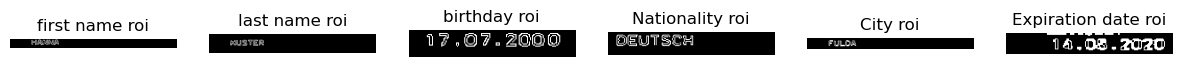

In [220]:
fig, axes = plt.subplots(1, 6, figsize = (15, 5))
firstname_roi = extract_firstname_roi(roi, axes[0])
lastname_roi = extract_lastname_roi(roi, axes[1])
birthday_roi = extract_birthday_roi(roi, axes[2])
nationality_roi = extract_nationality_roi(roi, axes[3])
city_roi = extract_city_roi(roi, axes[4])
expired_roi = extract_expiration_date_roi(roi, axes[5])
plt.show()

Step 8: Parse the text in the RoIs:

In [221]:
firstname = pytesseract.image_to_string(firstname_roi, lang='deu', config='--psm 6').strip()
lastname = pytesseract.image_to_string(lastname_roi, lang='deu', config='--psm 6').strip()
birthday = pytesseract.image_to_string(birthday_roi, lang='deu', config='--psm 6').strip()
city = pytesseract.image_to_string(city_roi, lang='deu', config='--psm 6').strip()
expiration_date = pytesseract.image_to_string(expired_roi, lang='deu', config='--psm 6').strip()
nationality = pytesseract.image_to_string(nationality_roi, lang='deu', config='--psm 6').strip()
print(f"First name: {firstname}, Last name: {lastname}, Birthday: {birthday}, City: {city}, Expiration Date: {expiration_date}, Nationality: {nationality}")


First name: HANNA, Last name: MUSTER, Birthday: 17.07.2000, City: FULDA, Expiration Date: 14.08.2020, Nationality: DEUTSCH
